In [1]:
%matplotlib
import torch
import torch.nn.functional as F

import torch_geometric
# from torch_geometric.nn import SAGEConv
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_dense_adj, add_self_loops

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.io as spio

import os
os.chdir("../")

import sys
sys.path.append('../scripts')

from evaluation import accuracy
from evaluation import areaundercurve
from evaluation import average_precision_score_computation

from encoders import Encoder
from aggregators import MeanAggregator

Using matplotlib backend: agg


In [2]:
class SAGEConv(torch.nn.Module):
    def __init__(self, in_channels, out_channels, normalize=False, bias=True):
        super(SAGEConv, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.normalize = normalize
        self.linear = torch.nn.Linear(self.in_channels, out_channels, bias=False)
        if bias:
            self.bias = torch.nn.Parameter(torch.Tensor(out_channels))
            torch.nn.init.zeros_(self.bias)
        else:
            self.register_parameter('bias', None)


    def forward(self, x, adj):
        out = torch.matmul(adj, x)
        out = out / adj.sum(dim=-1, keepdim=True).clamp(min=1)
        out = self.linear(out)

        if self.bias is not None:
            out = out + self.bias

        if self.normalize:
            out = F.normalize(out, p=2, dim=-1)

        return out

class Net(torch.nn.Module):
    def __init__(self, in_dim, out_dim, data):
        super(Net, self).__init__()
        self.conv1 = SAGEConv(in_dim, 16)
        self.conv2 = SAGEConv(16, out_dim)
        
        injection = torch.ones_like(data.adj) * 0.01
        injection = torch.abs(injection)
        self.injection = torch.nn.Parameter(
            injection, 
            requires_grad=True
        )

    def forward(self, data):
        x, adj = data.x, data.adj
        
        # link injection
        injection = F.relu(self.injection)
        adj = adj + injection
        adj = torch.clamp(adj, 0, 1)
        
        x = self.conv1(x, adj)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, adj)

        return F.log_softmax(x, dim=1)

In [3]:
from tqdm import tqdm

NUMEPOCHS = 10000
early_stop_win_size = 100
# tolerance = 0.005
tolerance = 1.00

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

# load data
name = 'Cora'
dataset = Planetoid('../datasets/'+ name, name=name)

in_dim = dataset.num_node_features
out_dim = dataset.num_classes

data = dataset.data
data.adj = to_dense_adj(add_self_loops(data.edge_index)[0])[0]
data = dataset.data.to(device)

# compile model
model = Net(
    in_dim,
    out_dim, 
    data
).to(device)

optimizer = torch.optim.Adamax(model.parameters(), weight_decay=0.005)

In [4]:
# get the initial injection
injection_init = model.injection.detach().cpu().numpy()

In [5]:
# record accuracy
train_acc = np.zeros(NUMEPOCHS)
val_acc = np.zeros(NUMEPOCHS)
test_acc = np.zeros(NUMEPOCHS)

# training start
model.train()

for epoch in range(NUMEPOCHS):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    
    loss.backward()
    optimizer.step()
    
    # record the accuracy
    train_acc[epoch] = accuracy(model, data, 'train')
    val_acc[epoch] = accuracy(model, data, 'val')
    test_acc[epoch] = accuracy(model, data, 'test')
    
    # early stopping
    if epoch > 2 * early_stop_win_size:
        prev_start = epoch - 2 * early_stop_win_size
        prev_end = epoch - early_stop_win_size
        current_start = epoch - early_stop_win_size
        current_end = epoch
        
        val_acc_current = np.mean(val_acc[current_start: current_end])
        val_acc_previous = np.mean(val_acc[prev_start: prev_end])
        
        if val_acc_current < val_acc_previous - tolerance:
            train_acc = train_acc[:epoch]
            val_acc = val_acc[:epoch]
            test_acc = test_acc[:epoch]
            print('Moving Average Early stopping at %d-th epoch' % epoch)
            print(
                'Previous validation average accuracy for %d-th to %d-th epoch: %f' % \
                (prev_start, prev_end, val_acc_previous)
            )
            print(
                'Current validation average accuracy for %d-th to %d-th epoch: %f' % \
                (current_start, current_end, val_acc_current)
            )
            break
    if epoch % 1000 == 0:
        print(
            epoch, 
            'training acc =', train_acc[epoch], 
            'validation acc =', val_acc[epoch], 
            ', loss =', loss.item()
        )

0 training acc = 0.14285714285714285 validation acc = 0.074 , loss = 1.9459091424942017
1000 training acc = 1.0 validation acc = 0.756 , loss = 0.04510412737727165
2000 training acc = 1.0 validation acc = 0.758 , loss = 0.03864774852991104
3000 training acc = 1.0 validation acc = 0.756 , loss = 0.03799137845635414
4000 training acc = 1.0 validation acc = 0.756 , loss = 0.037698764353990555
5000 training acc = 1.0 validation acc = 0.754 , loss = 0.03726394101977348
6000 training acc = 1.0 validation acc = 0.754 , loss = 0.03666199743747711
7000 training acc = 1.0 validation acc = 0.754 , loss = 0.036646079272031784
8000 training acc = 1.0 validation acc = 0.754 , loss = 0.03664026036858559
9000 training acc = 1.0 validation acc = 0.754 , loss = 0.03665505349636078


In [6]:
# get the initial injection
injection_final = F.relu(model.injection.detach()).cpu().numpy()

In [7]:
print('Initial injection = \n', injection_init)
print('\nSum inital = %d\n' % np.sum(injection_init))
print('Final injection = \n', injection_final)
print('\nSum final = %d\n' % np.sum(injection_final))

Initial injection = 
 [[0.01 0.01 0.01 ... 0.01 0.01 0.01]
 [0.01 0.01 0.01 ... 0.01 0.01 0.01]
 [0.01 0.01 0.01 ... 0.01 0.01 0.01]
 ...
 [0.01 0.01 0.01 ... 0.01 0.01 0.01]
 [0.01 0.01 0.01 ... 0.01 0.01 0.01]
 [0.01 0.01 0.01 ... 0.01 0.01 0.01]]

Sum inital = 73333

Final injection = 
 [[1.2725669e-04 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 2.2575747e-04]
 [0.0000000e+00 1.9313493e-04 2.0600981e-05 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 6.4821308e-04 2.0743354e-04 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 ...
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [2.3437459e-04 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  8.4344219e-06 0.0000000e+00]
 [1.7776266e-04 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 1.0550896e-06]]

Sum final = 574



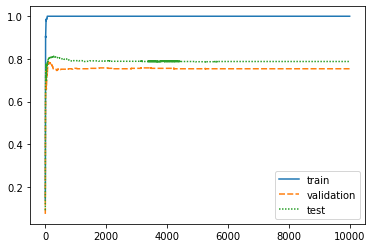

In [8]:
df_acc = pd.DataFrame({
    'train': train_acc,
    'validation': val_acc,
    'test': test_acc
})

sns.lineplot(data=df_acc)
plt.show()

In [9]:
spio.savemat('../variables/' +name + '/SAGEConv.mat',{
    'train': train_acc,
    'validation': val_acc,
    'test': test_acc
})

In [10]:
print('Train Accuracy: {:.4f}'.format(accuracy(model, data, 'train')))
print('Validation Accuracy: {:.4f}'.format(accuracy(model, data, 'val')))
print('Test Accuracy: {:.4f}'.format(accuracy(model, data, 'test')))

Train Accuracy: 1.0000
Validation Accuracy: 0.7540
Test Accuracy: 0.7880


In [11]:
print('Test AUC: {:.4f}'.format(areaundercurve(model,data,'test')))

Test AUC: 0.8842


In [12]:
#5 iterations has been completed

test_acc_all = np.array([0.7950, 0.7970, 0.7970, 0.7950, 0.7960])
test_auc_all = np.array([0.8841, 0.8865, 0.8849, 0.8861, 0.8831])


print(np.mean(test_acc_all))
print(np.mean(test_auc_all))

print(np.std(test_acc_all))
print(np.std(test_auc_all))

0.796
0.88494
0.0008944271909999167
0.0012547509713086396


[[  69   96]
 [  55 1366]
 [  55 1643]
 ...
 [2537  559]
 [2097 2133]
 [2052  525]]
[0.12132085 0.11121202 0.10681263 ... 0.0104484  0.01044711 0.01044649]
(10556, 2)
(10556,)


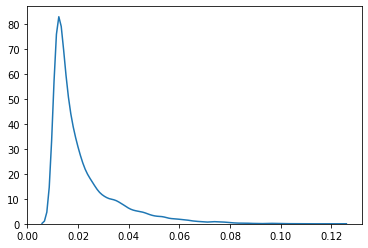

In [13]:
# get non-zero injected links
indexes = injection_final.nonzero()
index_arr = np.stack(indexes)
values = injection_final[indexes]

# sort injected links
sorted_idx = np.flip(np.argsort(values))

sorted_index = index_arr[:, sorted_idx]
sorted_values = values[sorted_idx]

# get the largest N out
num_edges = data.edge_index.size(1)
pred_index = sorted_index[:, :num_edges].T
pred_values = sorted_values[:num_edges]
print(pred_index)
print(pred_values)
print(pred_index.shape)
print(pred_values.shape)

sns.distplot(pred_values, hist=False)
plt.show()

In [14]:
# get the highest score out
print(pred_index[:10])
print(pred_values[:10])

[[  69   96]
 [  55 1366]
 [  55 1643]
 [  69 1372]
 [  23   96]
 [  55 1071]
 [  69  106]
 [  41   96]
 [  93   96]
 [  69 2461]]
[0.12132085 0.11121202 0.10681263 0.10448179 0.10388277 0.10088236
 0.09924897 0.09786578 0.09767627 0.09721683]


In [15]:
# get the highest score out
idx = np.where(pred_values > 0.5)
print(idx)
print(pred_index[idx])
print(pred_values[idx])

predicted_links = pred_index[idx]

(array([], dtype=int64),)
[]
[]
